### Sensor reading MQ136

Columns in ds7_train_df:
['TVC', 'MQ135', 'MQ136', 'MQ137', 'MQ138', 'MQ2', 'MQ3', 'MQ4', 'MQ5', 'MQ6', 'MQ8', 'MQ9']

DataFrame shape: (1554, 12)


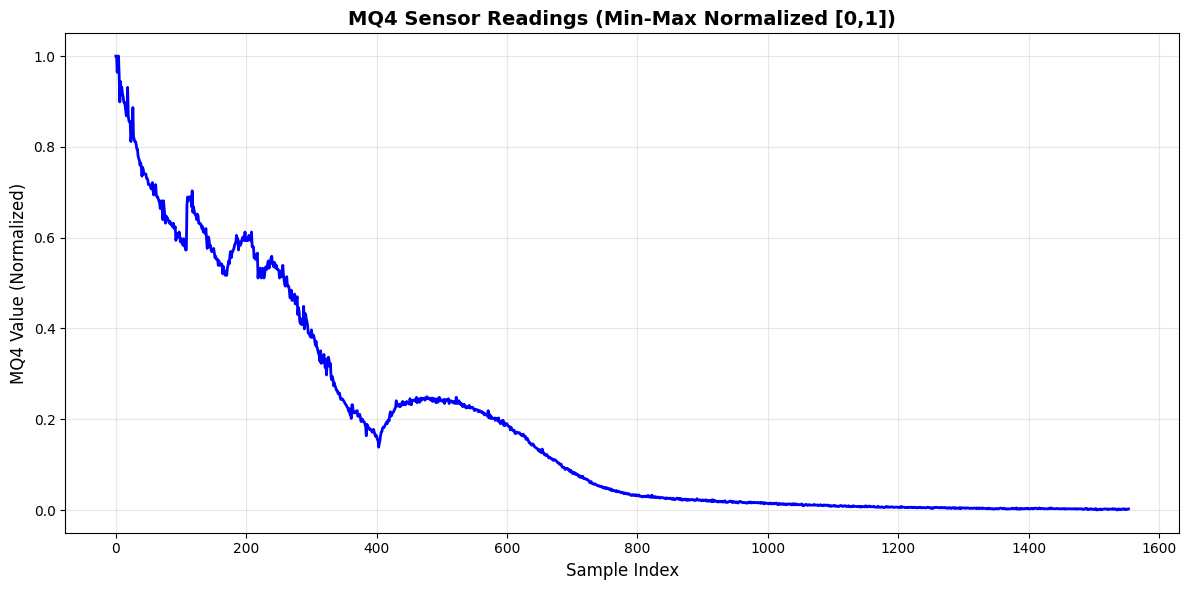

In [32]:
from notebook_resolver import *
import matplotlib.pyplot as plt
import numpy as np
from src.dataset import Dataset, WorkSheet
from src.utils.pandas_extension import *

dataset_path = "data/e-nose_dataset_12_beef_cuts.xlsx"

worksheet = WorkSheet.DS8.value
sensor = 'MQ4'

ds7_chart_dataset = Dataset(
	path=dataset_path, sheet_name=worksheet
)

ds7_train_df = ds7_chart_dataset.train_df

# Check if MQ136 column exists in ds7_train_df
print("Columns in ds7_train_df:")
print(ds7_train_df.columns.tolist())
print(f"\nDataFrame shape: {ds7_train_df.shape}")

# Create line chart of MQ136
if sensor in ds7_train_df.columns:
    # Apply Min-Max normalization to convert values to [0,1]
    sensor_values = ds7_train_df[sensor].values
    sensor_min = sensor_values.min()
    sensor_max = sensor_values.max()
    sensor_normalized = (sensor_values - sensor_min) / (sensor_max - sensor_min)

    # Create single plot for normalized values
    plt.figure(figsize=(12, 6))
    plt.plot(ds7_train_df.index, sensor_normalized, linewidth=2, color='blue')
    plt.title(f'{sensor} Sensor Readings (Min-Max Normalized [0,1])', fontsize=14, fontweight='bold')
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel(f'{sensor} Value (Normalized)', fontsize=12)
    plt.ylim(-0.05, 1.05)  # Add small margin for better visualization
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("MQ136 column not found in ds7_train_df!")
    print("Available columns:", ds7_train_df.columns.tolist())

### Visualize MQ136 clusters with scatter plot

In [33]:
# Demonstrate how cluster centers are sorted
from src.clusters import Cluster, ClusterContext, ClusteringMethod

# Create cluster instance
cluster = Cluster(cluster_ctx=ClusterContext.MFS, method=ClusteringMethod.MBKMEANS)

# Use the same sensor values as before
sensor_values = ds7_train_df[sensor].values
sensor_min = sensor_values.min()
sensor_max = sensor_values.max()
sensor_values = (sensor_values - sensor_min) / (sensor_max - sensor_min)

# Fit the cluster
cluster.strategy.fit(sensor_values)

print("Cluster Centers Information:")
print("="*50)

# Show raw cluster centers from sklearn (before sorting)
from sklearn.cluster import MiniBatchKMeans
mbkmeans = MiniBatchKMeans(n_clusters=len(cluster.strategy.centers_), random_state=42)
mbkmeans.fit(sensor_values.reshape(-1, 1))

print(f"Raw sklearn cluster_centers_: {mbkmeans.cluster_centers_.flatten()}")
print(f"Raw centers (unsorted): {mbkmeans.cluster_centers_.flatten()}")

# Show how centers are sorted
raw_centers = mbkmeans.cluster_centers_.flatten()
sorted_centers = np.sort(raw_centers)

print(f"Sorted centers: {sorted_centers}")
print(f"Our cluster.strategy.centers_: {cluster.strategy.centers_}")

print(f"\nSorting verification:")
print(f"Are they the same? {np.allclose(sorted_centers, cluster.strategy.centers_)}")

print(f"\nCenter sorting process:")
for i, (raw, sorted_val) in enumerate(zip(raw_centers, sorted_centers)):
    print(f"  Position {i}: Raw={raw:.4f} → Sorted={sorted_val:.4f}")

Cluster Centers Information:
Raw sklearn cluster_centers_: [0.22814614 0.01914945 0.62548685]
Raw centers (unsorted): [0.22814614 0.01914945 0.62548685]
Sorted centers: [0.01914945 0.22814614 0.62548685]
Our cluster.strategy.centers_: [0.02003552 0.22645064 0.61738746]

Sorting verification:
Are they the same? False

Center sorting process:
  Position 0: Raw=0.2281 → Sorted=0.0191
  Position 1: Raw=0.0191 → Sorted=0.2281
  Position 2: Raw=0.6255 → Sorted=0.6255


### How Cluster Centers Are Sorted

The cluster centers are automatically sorted in the MBK (Mini-Batch K-Means) clustering implementation:

1. **Raw Centers**: sklearn's MiniBatchKMeans produces cluster centers in random order
2. **Automatic Sorting**: The implementation uses `np.sort(centers_.flatten())` 
3. **Consistent Order**: This ensures centers are always ordered from lowest to highest value
4. **Why It Matters**: 
   - Provides consistent cluster numbering across runs
   - Makes visualization and analysis predictable
   - Cluster 0 = lowest center, Cluster 1 = next lowest, etc.

**Code Location**: `src/clusters/mbk_mfs_cluster.py` line 61:
```python
self.centers_ = np.sort(centers_.flatten())
```

Label Mapping (original_cluster → sorted_cluster):
  Original Cluster 1 (center: 0.0191) → Sorted Cluster 0
  Original Cluster 0 (center: 0.2281) → Sorted Cluster 1
  Original Cluster 2 (center: 0.6255) → Sorted Cluster 2


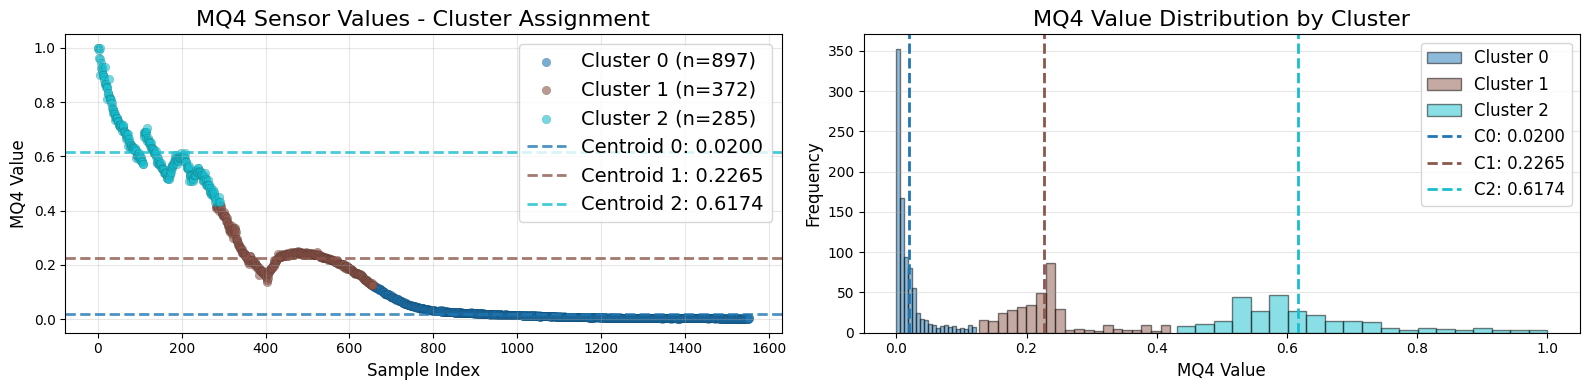


Cluster Statistics (with remapped labels):
------------------------------------------------------------
Cluster 0 (Color: #1f77b4):
  Centroid: 0.0200
  Size: 897 samples
  Range: [0.0000, 0.1232]
  Mean: 0.0192
  Std: 0.0250

Cluster 1 (Color: #8c564b):
  Centroid: 0.2265
  Size: 372 samples
  Range: [0.1263, 0.4206]
  Mean: 0.2288
  Std: 0.0614

Cluster 2 (Color: #17becf):
  Centroid: 0.6174
  Size: 285 samples
  Range: [0.4304, 1.0000]
  Mean: 0.6273
  Std: 0.1214



In [38]:
from src.clusters import Cluster, ClusterContext, ClusteringMethod
from sklearn.cluster import MiniBatchKMeans

cluster = Cluster(
    cluster_ctx=ClusterContext.MFS, method=ClusteringMethod.MBKMEANS
)

sensor_values = ds7_train_df[sensor].values
sensor_min = sensor_values.min()
sensor_max = sensor_values.max()
sensor_values = (sensor_values - sensor_min) / (sensor_max - sensor_min)

cluster.strategy.fit(sensor_values)

# SOLUTION: Create label remapping to match sorted centroids
# Get raw sklearn results to understand the original mapping
mbk_raw = MiniBatchKMeans(n_clusters=len(cluster.strategy.centers_), random_state=42)
mbk_raw.fit(sensor_values.reshape(-1, 1))
raw_centers = mbk_raw.cluster_centers_.flatten()
raw_labels = mbk_raw.labels_

# Create mapping from original cluster indices to sorted indices
sorted_indices = np.argsort(raw_centers)  # Get sorting order
label_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}

print("Label Mapping (original_cluster → sorted_cluster):")
for old_idx, new_idx in label_mapping.items():
    print(f"  Original Cluster {old_idx} (center: {raw_centers[old_idx]:.4f}) → Sorted Cluster {new_idx}")

# Remap labels to match sorted centroids
remapped_labels = np.array([label_mapping[label] for label in raw_labels])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Use consistent colors for all elements
colors = ['#1f77b4', '#8c564b', '#17becf', '#d62728', '#9467bd', '#8c564b']

# Plot 1: Scatter plot with REMAPPED cluster assignments
for i in range(len(cluster.strategy.centers_)):
    cluster_points_idx = remapped_labels == i  # Use remapped labels
    cluster_points = sensor_values[cluster_points_idx]
    
    ax1.scatter(
        np.where(cluster_points_idx)[0],
        cluster_points,
        c=colors[i],  # Consistent color
        label=f'Cluster {i} (n={len(cluster_points)})',
        alpha=0.6,
        s=40,
        edgecolors='k',
        linewidth=0.1
    )

# Add centroids as horizontal lines with matching colors
for i, center in enumerate(cluster.strategy.centers_):
    ax1.axhline(
        y=center,
        color=colors[i],  # SAME color as scatter points
        linestyle='--',
        linewidth=2,
        alpha=0.8,
        label=f'Centroid {i}: {center:.4f}'
    )

ax1.set_title(f'{sensor} Sensor Values - Cluster Assignment', fontsize=16)
ax1.set_xlabel('Sample Index', fontsize=12)
ax1.set_ylabel(f'{sensor} Value', fontsize=12)
ax1.legend(loc='best', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram with REMAPPED cluster distributions
for i in range(len(cluster.strategy.centers_)):
    cluster_points = sensor_values[remapped_labels == i]  # Use remapped labels
    ax2.hist(
        cluster_points,
        bins=20,
        alpha=0.5,
        color=colors[i],  # SAME color as scatter and lines
        label=f'Cluster {i}',
        edgecolor='black'
    )

# Add vertical lines for centroids with matching colors
for i, center in enumerate(cluster.strategy.centers_):
    ax2.axvline(
        x=center,
        color=colors[i],  # SAME color as histogram bars
        linestyle='--',
        linewidth=2,
        label=f'C{i}: {center:.4f}'
    )

ax2.set_title(f'{sensor} Value Distribution by Cluster', fontsize=16)
ax2.set_xlabel(f'{sensor} Value', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend(loc='best', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nCluster Statistics (with remapped labels):")
print("-"*60)
for i in range(len(cluster.strategy.centers_)):
    cluster_points = sensor_values[remapped_labels == i]  # Use remapped labels
    print(f"Cluster {i} (Color: {colors[i]}):")
    print(f"  Centroid: {cluster.strategy.centers_[i]:.4f}")
    print(f"  Size: {len(cluster_points)} samples")
    if len(cluster_points) > 0:
        print(f"  Range: [{cluster_points.min():.4f}, {cluster_points.max():.4f}]")
        print(f"  Mean: {cluster_points.mean():.4f}")
        print(f"  Std: {cluster_points.std():.4f}")
    print()

### TSK Membership Functions

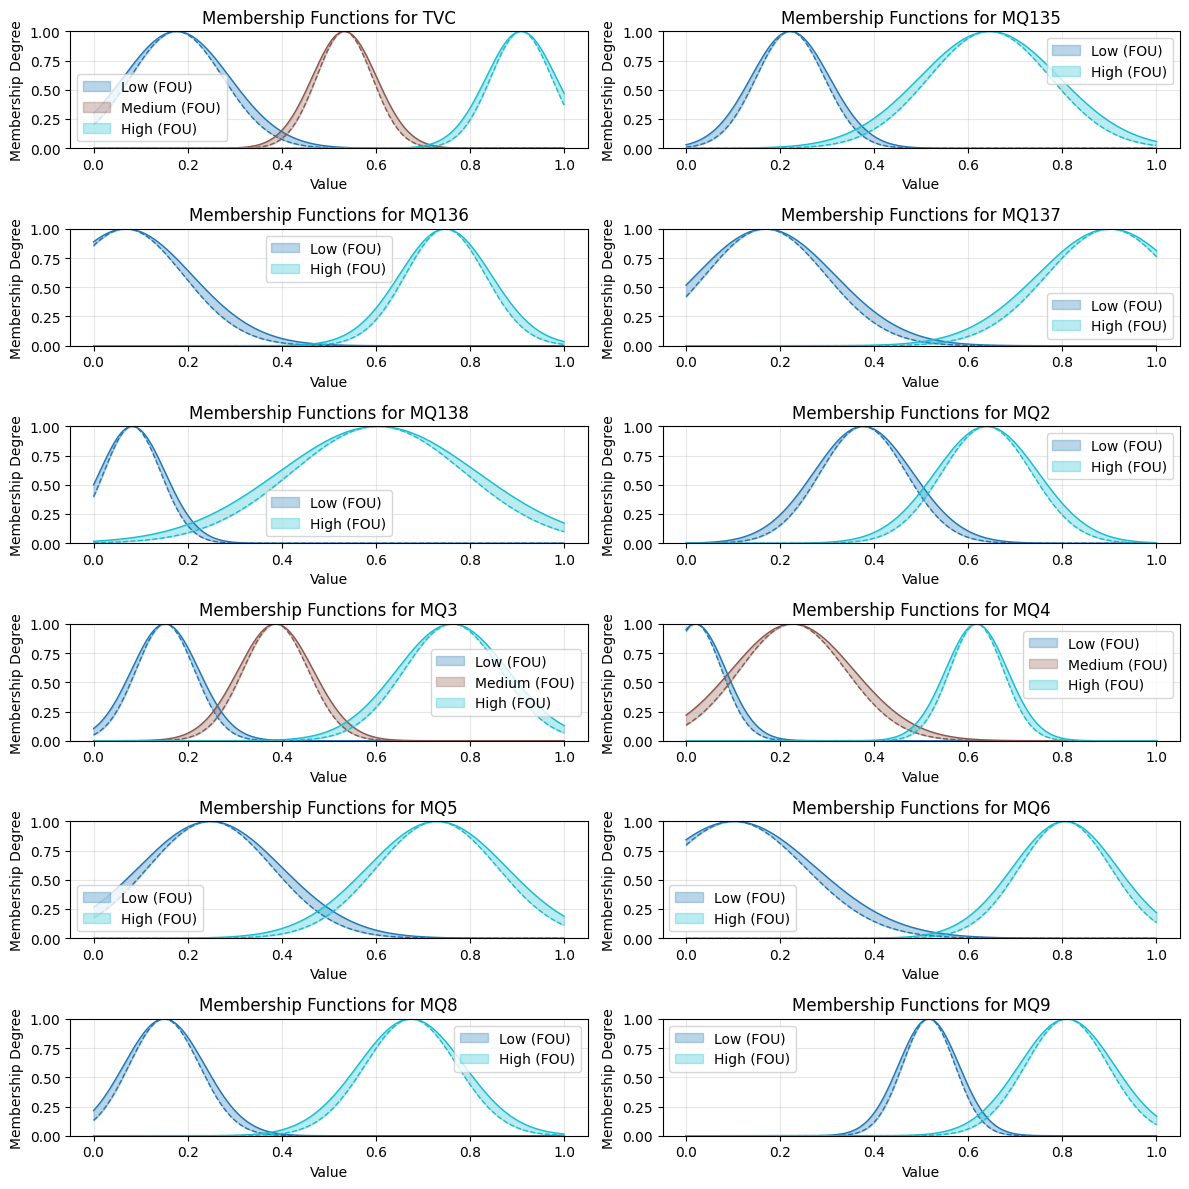

In [35]:
from src.pipeline import Pipeline
from src.pipelines.transformers import FeatureScaler

from src.pipelines.predictors import TskPredictor, IT2TskPredictor
from src.fis.fuzzy_logic.mfs import MFType1, MFType2
from src.fis.fuzzy_logic.consequents import LinearModel
from src.clusters import ClusteringMethod
from src.pipelines.transformers import FeatureScaler, CorrelationScoreSelector
from src.utils.hyperparameter import get_tuned_params

tuned_params = get_tuned_params()[worksheet]

target_column = 'TVC'

tsk_pipeline = Pipeline(steps=[
	('feature_scaler', FeatureScaler(decimal_places=4)),
	("feature_selection", CorrelationScoreSelector(target=target_column)),
	('predictor', IT2TskPredictor(target=target_column))
])

tsk_pipeline.fit(
    ds7_train_df, # pipeline fit only for training dataframe
    predictor__clustering_method=ClusteringMethod.MBKMEANS,
	predictor__mf_type=MFType2.GAUSSIAN,
    predictor__linear_model=LinearModel.LSE,
    predictor__mf__builder__uncertainty_factor=tuned_params.get(
		"uncertainty_factor"
	),
	predictor__mf__builder__min_std_ratio=tuned_params.get(
		"min_std_ratio"
	),	
)

tsk_predictor = tsk_pipeline.named_steps['predictor']

tsk_predictor.plot_mfs_grid()

### IT2TSK Membership Functions

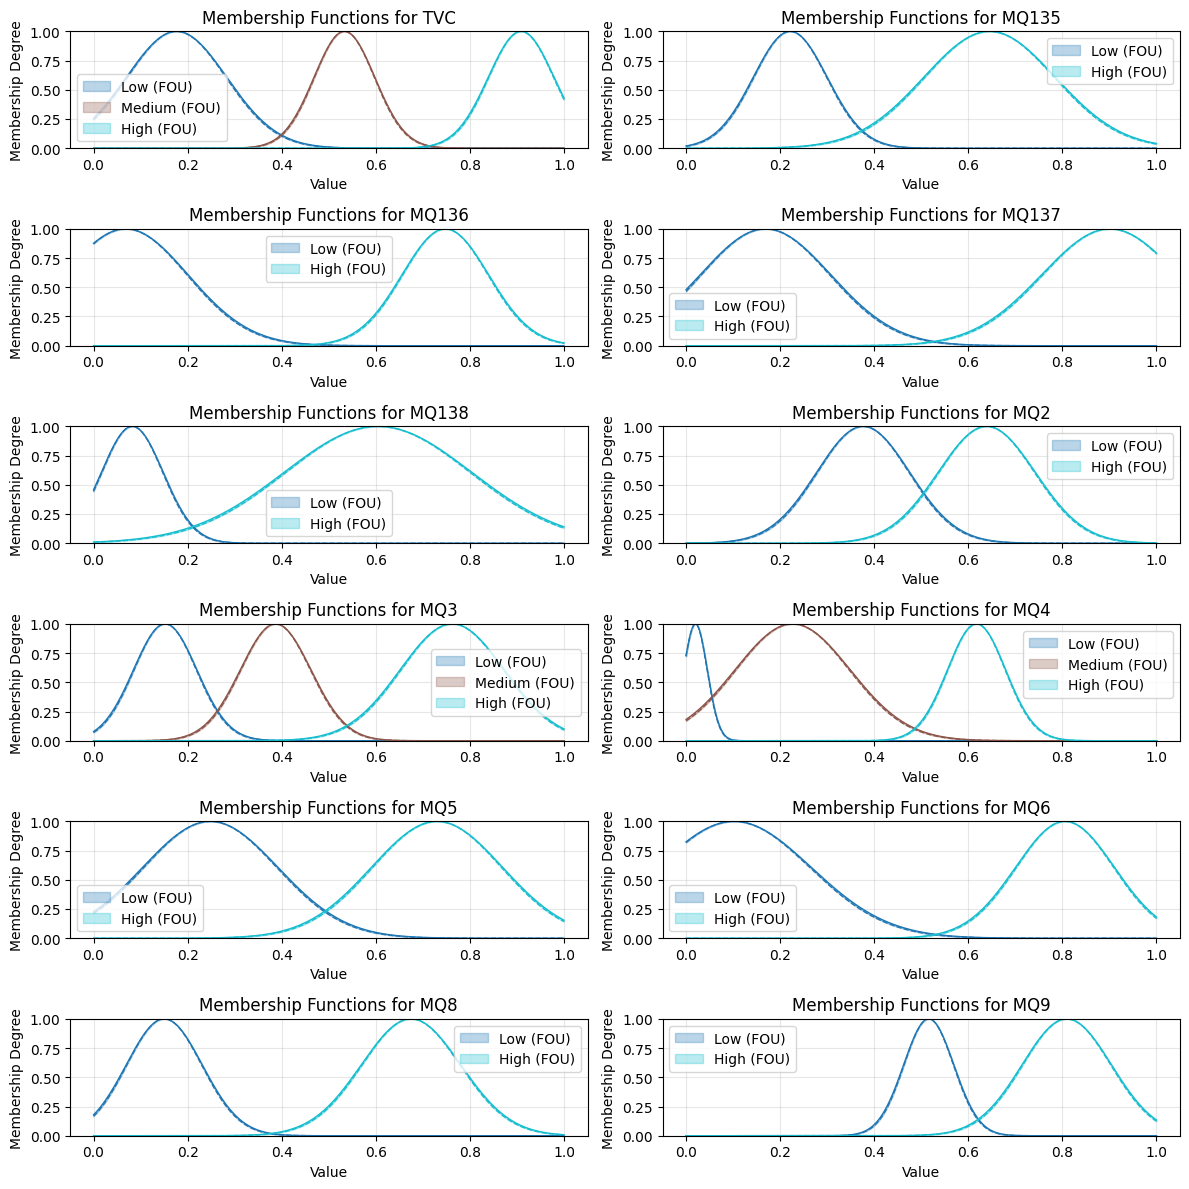

In [36]:
it2tsk_pipeline = Pipeline(steps=[
	('feature_scaler', FeatureScaler(decimal_places=4)),
	("feature_selection", CorrelationScoreSelector(target=target_column)),
	('predictor', IT2TskPredictor(target=target_column))
])

it2tsk_pipeline.fit(
    ds7_train_df, # pipeline fit only for training dataframe
    predictor__clustering_method=ClusteringMethod.MBKMEANS,
	predictor__mf_type=MFType2.GAUSSIAN,
    predictor__linear_model=LinearModel.LSE,
)

it2tsk_predictor = it2tsk_pipeline.named_steps['predictor']

it2tsk_predictor.plot_mfs_grid()

### Selected Model (IT2TSK - MBK-Means - Gaussian MF)

In [37]:
from src.utils.excel_operation import export_to_excel

file_path = "experiments/Mamdani_TSK_Selection.xlsx"

df = pd.read_excel(file_path, sheet_name="fis_selection")

selected_df = df[
    (df["FIS Type"] == "it2_tsk") & 
    (df["Clustering Method"] == "ClusteringMethod.MBKMEANS") &
    (df["MFs Type"] == "MFType2.GAUSSIAN")]


selected_model_df = selected_df[[
    "Worksheet Name",
    "R2",
    "MSE",
    "MAE",
    "total_rule_base_clustering_time",
    "total_rules",
    "total_features_clustering_time",
    "total_features"]].round(4)

# Calculate averages and totals
avg_r2 = selected_model_df["R2"].mean()
avg_mse = selected_model_df["MSE"].mean()
avg_mae = selected_model_df["MAE"].mean()
avg_rule_base_time = selected_model_df["total_rule_base_clustering_time"].mean()
avg_features_time = selected_model_df["total_features_clustering_time"].mean()

# Create a summary row as a DataFrame
summary_row = pd.DataFrame({
    "Worksheet Name": ["Average"],
    "R2": [avg_r2],
    "MSE": [avg_mse],
    "MAE": [avg_mae],
    "total_rule_base_clustering_time": [avg_rule_base_time],
    "total_rules": [""],
    "total_features_clustering_time": [avg_features_time],
    "total_features": [""]
})

# Append to the original DataFrame
final_df = pd.concat([selected_model_df, summary_row], ignore_index=True)

# Round numeric columns for presentation
final_df[["R2", "MSE", "MAE", 
          "total_rule_base_clustering_time", 
          "total_features_clustering_time"]] = final_df[[
              "R2", "MSE", "MAE", 
              "total_rule_base_clustering_time", 
              "total_features_clustering_time"
          ]].astype(float).round(4)

# Display result
final_df

,Worksheet Name,R2,MSE,MAE,total_rule_base_clustering_time,total_rules,total_features_clustering_time,total_features
0,1.Inside-Outside,0.9776,0.0020,0.0328,0.6982,2,5.2767,12
1,2.Round,0.9917,0.0007,0.0189,0.7885,2,5.5890,12
2,3.Top_Sirloin,0.9745,0.0022,0.0304,0.7824,2,5.3380,12
3,4.Tenderloin,0.9789,0.0018,0.0242,0.6852,3,5.3738,12
4,5.Flap_meat,0.9858,0.0012,0.0254,0.6321,2,7.0702,12
5,6.Striploin,0.9894,0.0009,0.0217,0.7923,2,5.5180,12
6,7.Rib_eye,0.9923,0.0007,0.0188,4.7033,2,6.0533,12
7,8.Skirt_meat,0.9945,0.0005,0.0140,0.6926,3,5.2510,12
8,9.Brisket,0.9919,0.0007,0.0175,0.8042,2,5.2768,12
9,10.Clod_Chuck,0.9450,0.0047,0.0419,0.6921,2,5.6115,12
